In [55]:
import pandas as pd

import numpy as np
import sys, os
import scipy.stats

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib

from matplotlib import pyplot

import re

matplotlib.rcParams['xtick.major.size'] = 8
matplotlib.rcParams['xtick.major.width'] = 2.5
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['xtick.minor.size'] = 4
matplotlib.rcParams['xtick.minor.width'] = 1

matplotlib.rcParams['ytick.major.size'] = 8
matplotlib.rcParams['ytick.major.width'] = 2.5
matplotlib.rcParams['ytick.direction'] = 'out'
matplotlib.rcParams['ytick.minor.size'] = 4
matplotlib.rcParams['ytick.minor.width'] = 1

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = 'Arial'

# function to change width
def change_width(ax, new_value):
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        # change the bar width
        patch.set_width(new_value)
        # recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

In [56]:
from matplotlib.patches import PathPatch

def adjust_box_widths(g, fac):
    """
    Adjust the widths of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.array_equal(l.get_xdata(), [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

In [57]:
# import splicing measurements and compute spliced fraction (= 1 - full length fraction)
HELA = pd.read_csv('ptreseq_splicing_quantification/HELA_2rep_fraction.txt', sep = '\t')
HELA['spliced_fraction'] = 1 - HELA['fraction']
HELA = HELA[HELA['best_category']=='full_length']

In [58]:
# spliceAI prediction
# see get_best_site.py script on cluster for details on how to generate the file
spliceai = pd.read_csv('data/ptreseq_full_transcript_prediction_best_sites.txt', sep = '\t')

def custom_mode_agg(series):
    modes = series.mode()
    if modes.empty:
        return np.nan # Or any other placeholder if no mode
    elif len(modes) == 1:
        return modes.iloc[0] # Return the single mode
    else:
        if 715 in modes.to_list():
            return 715 # Return all modes as a list if there are multiple
        else:
            return modes.iloc[0]

        
medspliceai = spliceai.groupby('plasmid').agg({'best_donor': custom_mode_agg,
                                               'donor_prob': 'median',
                                               'best_acceptor': custom_mode_agg,
                                              'acceptor_prob': 'median'}).reset_index()

def replace_site(d, a):
    if type(d) is np.ndarray:
        donor = d[-1]
    else:
        donor = d
        
    if type(a) is np.ndarray:
        acceptor = a[-1]
    else:
        acceptor = a
        
    return donor, acceptor

medspliceai['best_donor'], medspliceai['best_acceptor'] = zip(*medspliceai.apply(lambda g: 
                                                                            replace_site(g['best_donor'],
                                                                                        g['best_acceptor']), 
                                                                                 axis = 1))
medspliceai['splicing_prob'] = medspliceai['donor_prob']*medspliceai['acceptor_prob']

# merge measured splicing percentage with spliceAI prediction
m = HELA.merge(medspliceai, left_on = 'RE', right_on = 'plasmid')

## Figure 5A: spliceAI probability is positivly correlated with PTRE-seq splicing measurements

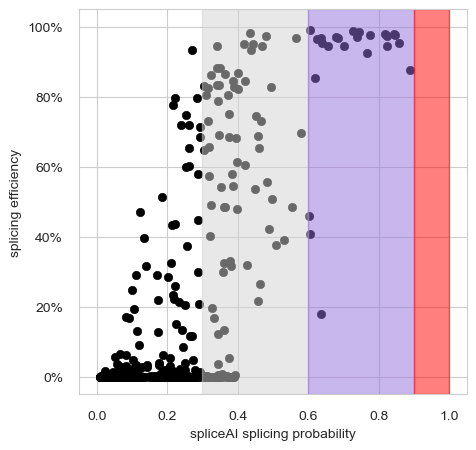

In [59]:
f, ax = plt.subplots(figsize = (5, 5))

sns.scatterplot(
    data = m, 
    x = 'splicing_prob', 
    y = 'spliced_fraction', 
    color = 'black',
    edgecolor = None,
    ax = ax)

# for spliceAI
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

ax.fill_between([0.3, 0.6], -0.05, 1.05, color = 'lightgrey', alpha = 0.5)
ax.fill_between([0.6, 0.9], -0.05, 1.05, color = 'mediumpurple', alpha = 0.5)
ax.fill_between([0.9, 1.0], -0.05, 1.05, color = 'red', alpha = 0.5)

ax.set_xlabel('spliceAI splicing probability')
ax.set_ylabel('splicing efficiency')

f.savefig('PLOTS/Fig_5A.pdf', transparent = True)

### Pangolin prediction results (not shown in manuscript)

Text(0, 0.5, 'splicing efficiency')

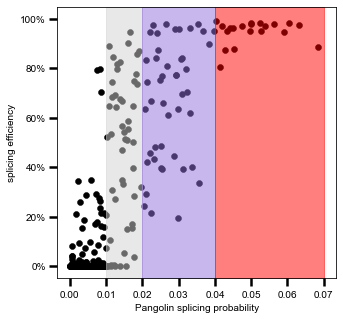

In [8]:
# Pangolin prediction
pangolin = pd.read_csv('data/PTREseq_pangolin_prediction.txt', sep = '\t')
pangolin = pangolin.groupby('plasmid').agg({'best_donor': pd.Series.mode,
                                               'donor_prob': 'median',
                                               'best_acceptor': pd.Series.mode,
                                              'acceptor_prob': 'median'}).reset_index()

def replace_site(d, a):
    if type(d) is np.ndarray:
        donor = d[-1]
    else:
        donor = d
        
    if type(a) is np.ndarray:
        acceptor = a[-1]
    else:
        acceptor = a
        
    return donor, acceptor

pangolin['best_donor'], pangolin['best_acceptor'] = zip(*pangolin.apply(lambda g: 
                                                                            replace_site(g['best_donor'],
                                                                                        g['best_acceptor']), 
                                                                                 axis = 1))
pangolin['splicing_prob'] = pangolin['donor_prob']*pangolin['acceptor_prob']

# merge measured splicing percentage with spliceAI prediction
m = HELA.merge(pangolin, left_on = 'RE', right_on = 'plasmid')

f, ax = plt.subplots(figsize = (5, 5))

# Plot prediction
sns.scatterplot(
    data = m, 
    x = 'splicing_prob', 
    y = 'spliced_fraction', 
    color = 'black',
    edgecolor = None,
    ax = ax)

ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

#ax.set_xlabel('spliceAI splicing probability')
ax.set_xlabel('Pangolin splicing probability')
ax.set_ylabel('splicing efficiency')

#for pangolin usage
ax.set_ylim(-0.05, 1.05)

ax.fill_between([0.01, 0.02], -0.05, 1.05, color = 'lightgrey', alpha = 0.5)
ax.fill_between([0.02, 0.04], -0.05, 1.05, color = 'mediumpurple', alpha = 0.5)
ax.fill_between([0.04, 0.07], -0.05, 1.05, color = 'red', alpha = 0.5)

ax.set_xlabel('Pangolin splicing probability')
ax.set_ylabel('splicing efficiency')

#f.savefig('Pangoline_prediction.pdf', transparent = True)

## Evaluate published MPRAs

### Import Griesemer MPRA results

In [60]:
# Import splicing prediction results from SpliceAI
import math
griesemer_splice = pd.read_csv('data/griesemer_spliceai_full_transcript_prediction_best_sites.txt', sep = '\t')
griesemer_splice['probability'] = griesemer_splice['donor_prob']*griesemer_splice['acceptor_prob']

# replace name to match naming from original publication
def changename(seqid):
    
    if 'ref' in seqid:
        seqid = seqid.replace('_ref', '') + '_ref'
        mpra_variant_id = seqid.replace('_ref', '')
        allele = 'ref'
    elif 'alt' in seqid:
        seqid = seqid.replace('_alt', '') + '_alt'
        mpra_variant_id = seqid.replace('_alt', '')
        allele = 'alt'
    else:
        mpra_variant_id = seqid
        allele = np.nan

    mpra_variant_id = mpra_variant_id.replace("3-", "3'").replace("5-", "5'")
        
    return seqid, mpra_variant_id, allele
        
griesemer_splice['name'], griesemer_splice['mpra_variant_id'], griesemer_splice['allele'] = zip(
    *griesemer_splice[
    'seq_id'
].apply(
    lambda g: changename(g)
)
                                                          )

# Import measurements from original publication
griesemer_result = pd.read_excel(
    'data/griesemer_expression_measurements.xlsx', 
    sheet_name = 'Variant MPRAu Results',
    engine ='openpyxl'
)
# convert dataframe to long form and fix name to match spliceAI output
gresult = pd.melt(griesemer_result, id_vars = 'mpra_variant_id', var_name = 'allele', value_name = 'log2FoldChange', 
        value_vars = ['log2FoldChange_Ref_HEK293FT', 'log2FoldChange_Alt_HEK293FT'])

def combine_name(seqid, allele):
    if 'Ref' in allele:
        return seqid + '_ref'
    elif 'Alt' in allele:
        return seqid + '_alt'
    
gresult['name'] = gresult.apply(lambda g: combine_name(g['mpra_variant_id'], g['allele']), axis = 1)

# combine spliceai prediction and expression measurements
griesemer = griesemer_splice.merge(gresult, on = 'name', how = 'outer')
griesemer = griesemer.dropna(subset = ['seq_id'])

### Siegel MPRA

In [61]:
# import splicing prediction from SpliceAI
siegel = pd.read_csv('data/siegel_spliceai_full_transcript_prediction_best_sites.txt', sep = '\t')
siegel['probability'] = siegel['donor_prob']*siegel['acceptor_prob']

# import expression measurements from jurkat cell lines
siegel_jurkat = pd.read_csv('data/siegel_expression_measurements_jurkat.csv')
temp = siegel_jurkat.reset_index()
temp['seq_id'] = temp.apply(lambda g: g['region']+'_'+str(g['index']), axis = 1)

# combine spliceai prediction and expression measurements
siegel = siegel.merge(temp, on = 'seq_id')

### Zhao MPRA

In [62]:
# import splicing prediction
zhao = pd.read_csv('data/zhao_spliceai_full_transcript_prediction_best_sites.txt', sep = '\t')
zhao['probability'] = zhao['donor_prob']*zhao['acceptor_prob']

# import expression measurements
zhao_beas2b = pd.read_excel('data/zhao_expression_measurements.xlsx', skiprows = 5, engine ='openpyxl')

# combine spliceai prediction and expression measurements
zhao = zhao.merge(zhao_beas2b, left_on = 'seq_id', right_on = 'segment_id')
zhao = zhao.replace('nd', np.nan)

### Fu MPRA (MapUTR)

In [63]:
# import splicing prediction
fu = pd.read_csv('data/fu_spliceai_full_transcript_prediction_best_sites.txt', sep = '\t')
fu['probability'] = fu['donor_prob']*fu['acceptor_prob']

# import expression measurements
#fu_exp = pd.read_csv('data/fu_expression_measurements_HEK293.txt', sep = '\t') # for HEK cells (not shown in main text)
fu_exp = pd.read_csv('data/fu_expression_measurements_HELA.txt', sep = '\t') # for HeLa cells
fu_exp['avg'] = fu_exp.median(numeric_only = True, axis = 1)

# combine spliceai prediction and expression measurements
fum = fu_exp.merge(fu, left_on = 'Variant', right_on = 'seq_id', how = 'inner')

# normalize exp
med = fum[fum['probability']<=0.30]['avg'].median()
fum['log2FoldChange'] = fum['avg'].apply(lambda g: np.log2(g/med))

## Figure 5C: percent of reporters predicted to be spliced

In [64]:
# add probability bins for spliceAI

def prediction(prob):
    if prob <= 0.30:
        return '0-0.30'
    elif prob <= 0.60:
        return '0.30-0.60'
    elif prob <= 0.90:
        return '0.60-0.90'
    else:
        return '0.90-1.00'

metric = 'probability'

# For Griesemer MPRA
griesemer['prediction'] = griesemer[metric].apply(lambda g: prediction(g))
toplot1 = griesemer[['prediction', metric, 'log2FoldChange']].reset_index(drop=True)
toplot1['mpra'] = 'griesemer'

# For Siegel MPRA
siegel['prediction'] = siegel[metric].apply(lambda g: prediction(g))
siegel_median = siegel['ratios_T0_GC_resid'].median() # Use ratios_T0 as measurement, adjusted for GC content
siegel['log2FoldChange'] = siegel['ratios_T0_GC_resid'].apply(lambda g: np.log2(g/siegel_median))
toplot2 = siegel[['prediction', metric, 'log2FoldChange']].reset_index(drop=True)
toplot2 = toplot2[~toplot2['log2FoldChange'].isin([-np.inf])]
toplot2['mpra'] = 'siegel'

# For Zhao MPRA
zhao['prediction'] = zhao[metric].apply(lambda g: prediction(g))
zhao['log2FoldChange'] = zhao['BEAS-2B log2 steady state mRNA']
toplot3 = zhao[['prediction', metric, 'log2FoldChange']].reset_index(drop=True)
toplot3['mpra'] = 'zhao'

# For MapUTR
fum['prediction'] = fum[metric].apply(lambda g: prediction(g))
fum['log2FoldChange'] = fum['log2FoldChange']
toplot4 = fum[['prediction', metric, 'log2FoldChange']].reset_index(drop = True)
toplot4['mpra'] = 'fu'

toplot = pd.concat([toplot1, toplot2, toplot3, toplot4])

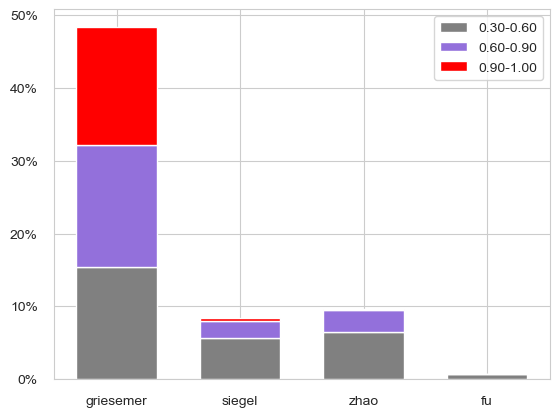

In [65]:
# count number of reporters for each splicing probability bin
figure3c = toplot.groupby('mpra')['prediction'].value_counts().to_frame(name = 'count').reset_index()
# compute fraction in each bin
figure3c['fraction'] = figure3c.groupby('mpra', group_keys = False)['count'].apply(lambda g: g/g.sum())
figure3c = figure3c.sort_values(by='mpra')

# for spliceAI
figure3c = figure3c[figure3c['prediction']!='0-0.30']
figure3c = figure3c.reindex([7, 5, 6, 9, 10, 11, 13, 14, 15, 1, 2, 3]) # reorder x axis
#print(figure3c)

# Barplot
f, ax = plt.subplots()

bottom = np.array([0.0]*4)
for prediction, color in zip(['0.30-0.60', '0.60-0.90', '0.90-1.00'], ['grey', 'mediumpurple', 'red']):
    temp = figure3c[figure3c['prediction']==prediction].reset_index(drop = True)
    x_axis = temp['mpra'].to_numpy()
    y_axis = temp['fraction'].to_numpy()
    ax.bar(x_axis, y_axis, bottom = bottom,
          width = 0.65, label = prediction, color = color)
    
    bottom += temp['fraction'].to_numpy()

# format y axis
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
ax.set_yticklabels(['0%', '10%', '20%', '30%', '40%', '50%'])   

ax.legend() # show legend

f.savefig('PLOTS/Fig_5C.pdf', transparent = True)

## Figure 5D: location of predicted splice sites

In [66]:
# combine all 4 MPRAs
cols = ['best_donor', 'best_acceptor', 'probability']

griesemer_1 = griesemer_splice[cols].reset_index(drop = True)
griesemer_1['mpra'] = 'griesemer'

siegel_1 = siegel[cols].reset_index(drop = True)
siegel_1['mpra'] = 'siegel'

zhao_1 = zhao[cols].reset_index(drop = True)
zhao_1['mpra'] = 'zhao'

fu_1 = fu[cols].reset_index(drop = True)
fu_1['mpra'] = 'fu'

all_mpra = pd.concat([griesemer_1, siegel_1, zhao_1, fu_1])
all_mpra = all_mpra[all_mpra['probability']>0.3]

# input sequence have all been normalized such that end of GFP CDS is 720
all_mpra['donor_loc'] = all_mpra['best_donor'].apply(lambda g: 'GFP' if g <= 720 else 'UTR')
all_mpra['acceptor_loc'] = all_mpra['best_acceptor'].apply(lambda g: 'GFP' if g <= 720 else 'UTR')

# count number of predicted donors in GFP CDS vs 3 UTR
donor_loc = all_mpra.groupby('mpra')['donor_loc'].value_counts().to_frame().rename(columns = {'donor_loc': 'count'}).reset_index()
donor_loc['per'] = donor_loc.groupby('mpra')['count'].transform(lambda g: g/g.sum())

# count number of predicted acceptors in GFP CDS vs 3 UTR
acceptor_loc = all_mpra.groupby('mpra')['donor_loc'].value_counts().to_frame().reset_index()
acceptor_loc['per'] = acceptor_loc.groupby('mpra')['count'].transform(lambda g: g/g.sum())

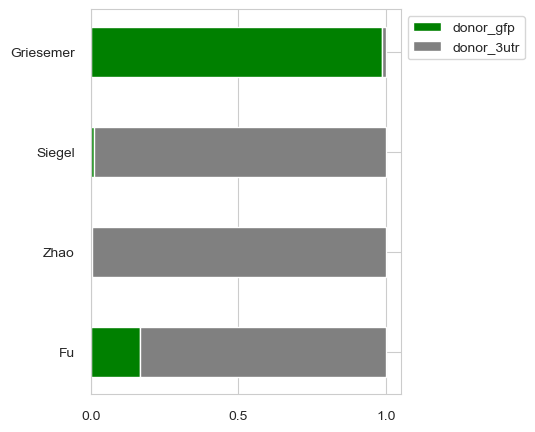

In [67]:
# plot stacked bar chart
# in main text, only donor is shown
order = ['griesemer', 'siegel', 'zhao', 'fu']

donor_gfp = []
donor_utr = []
for mpra in order:
    val = donor_loc[(donor_loc['donor_loc']=='GFP')&(donor_loc['mpra']==mpra)]['per'].values[0]
    donor_gfp.append(val)
    
    val = donor_loc[(donor_loc['donor_loc']=='UTR')&(donor_loc['mpra']==mpra)]['per'].values[0]
    donor_utr.append(val)

f, ax = plt.subplots(figsize = (4, 5))

ax.barh([0, -1, -2, -3], donor_gfp, height = 0.5, label = 'donor_gfp', color = 'green')
ax.barh([0, -1, -2, -3], donor_utr, height = 0.5, left = donor_gfp, label = 'donor_3utr', color = 'grey')

ax.set_xticks([0, 0.5, 1.0])

ax.set_yticks(range(-3, 1))
ax.set_yticklabels(['Fu', 'Zhao', 'Siegel', 'Griesemer'])

ax.legend(bbox_to_anchor = (1, 1))

f.savefig('PLOTS/Fig_5D.pdf', transparent = True)

## Figure 5E: Top motif enriched in spliced vs unspliced reporters

In [31]:
import logomaker

def plot_sequence_logo(fn, motif_length, motif_no, out = None):
    found = False
    n = 0
    data = []
    motif = 0

    with open(fn, 'r') as fn:
        for line in fn:
            if 'letter-probability matrix' in line: 
                motif += 1
                if motif == motif_no: 
                    found = True
                    continue

            if found and n < motif_length:
                n += 1
                spl = [float(i) for i in line.rstrip().replace(' ', '').split('\t')]
                data.append(spl)

    df = pd.DataFrame(data, columns = ['A', 'C', 'G', 'U'])
    
    # Define a function to compute entropy for each row (sequence position)
    def compute_entropy(row):
        eps = 1e-10  # Small value to avoid log(0)
        row = np.clip(row, eps, 1.0)  # Ensure no zero values
        entropy = - np.sum(row * np.log2(row))  # Shannon entropy
        return entropy

    # Compute the maximum entropy for DNA (4 possible nucleotides: A, C, G, T)
    H_max = np.log2(4)  # H_max = 2 bits for DNA

    # Apply the entropy function to each row (sequence position)
    entropy = df.apply(compute_entropy, axis=1)

    # Compute the information content (bits) for each position
    total_information_content = H_max - entropy

    # Now, compute the information content for each nucleotide at each position
    for nucleotide in ['A', 'C', 'G', 'U']:  # Exclude 'Entropy' and 'Total Information Content'
        df[nucleotide] = df[nucleotide] * total_information_content

    f, ax = plt.subplots(figsize = (5, 2))
    
    # create Logo object
    ss_logo = logomaker.Logo(df, shade_below=.5, fade_below=.5, font_name='Arial Rounded MT Bold', ax = ax)


    # style using Logo methods
    ss_logo.style_spines(spines=['right', 'top'], visible=False)

    # style using Axes methods
    ss_logo.ax.set_xticks(range(len(df)))
    ss_logo.ax.set_xticklabels([i for i in range(1, len(df)+1)])

    ss_logo.ax.set_yticks([0, 1, 2])
    ss_logo.ax.set_ylabel('bits', fontsize=14)

    if out:
        f.savefig(out, transparent = True)

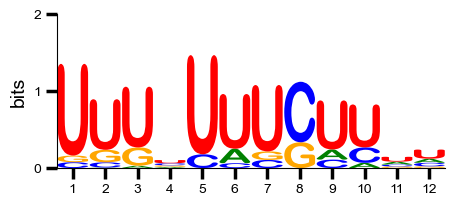

In [32]:
# Griesemer motif
plot_sequence_logo('data/griesemer_motif_analysis.txt', 12, 1, 'PLOTS/Fig_6E_griesemer_best_motif.pdf')

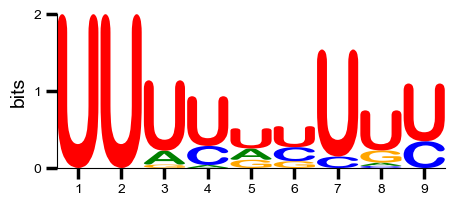

In [33]:
# Siegel motif
plot_sequence_logo('data/siegel_motif_analysis.txt', 9, 2, 'PLOTS/Fig_6E_siegel_best_motif.pdf')

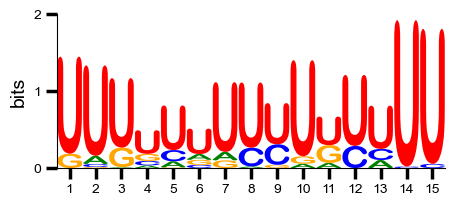

In [34]:
# Zhao motif
plot_sequence_logo('data/zhao_motif_analysis.txt', 15, 1, 'PLOTS/Fig_6E_zhao_best_motif.pdf')

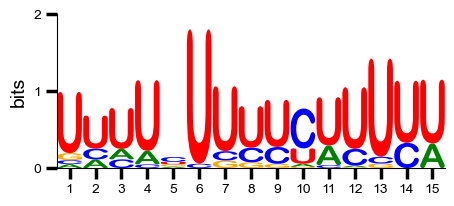

In [35]:
# Fu motif
plot_sequence_logo('data/fu_motif_analysis.txt', 15, 1, 'PLOTS/Fig_6E_fu_best_motif.pdf')

## Figure 5F: Splicing prediction and expression measurements

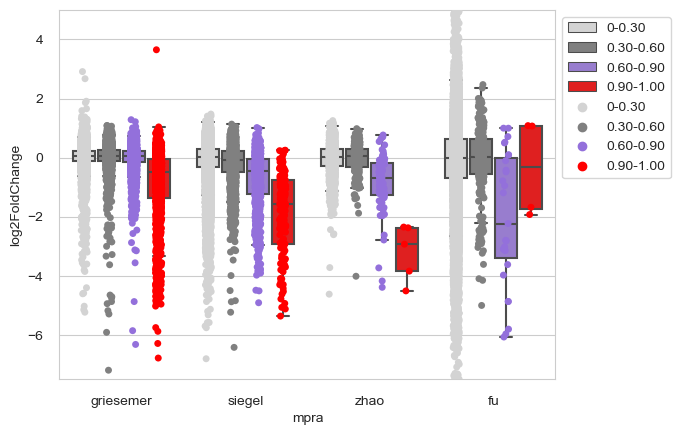

In [68]:
f, ax = plt.subplots()

sns.boxplot(
    data = toplot.reset_index(), 
    x = 'mpra', 
    y = 'log2FoldChange', 
    hue = 'prediction', 
    order = ['griesemer', 'siegel', 'zhao', 'fu'],
    palette = ['lightgrey', 'grey', 'mediumpurple', 'red'],
    hue_order = ['0-0.30', '0.30-0.60', '0.60-0.90', '0.90-1.00'],
    fliersize = 0,
    ax = ax
)

sns.stripplot(
    data = toplot.reset_index(), 
    x = 'mpra', 
    y = 'log2FoldChange', 
    hue = 'prediction', 
    order = ['griesemer', 'siegel', 'zhao', 'fu'],
    palette = ['lightgrey', 'grey', 'mediumpurple', 'red'],
    hue_order = ['0-0.30', '0.30-0.60', '0.60-0.90', '0.90-1.00'],
    dodge = True,
    ax = ax
)


ax.set_ylim(-7.5, 5)

adjust_box_widths(f, 0.90)

ax.legend(bbox_to_anchor = (1, 1))
f.savefig('PLOTS/Fig_5F.pdf', transparent = True)

In [69]:
# statistical test for difference using mann whitney u test
for df, mpra in zip([toplot1, toplot2, toplot3, toplot4], ['Griesemer', 'Siegel', 'Zhao', 'Fu']):
    
    print(f'{mpra} MPRA')
    
    a = df[df['prediction']=='0-0.30'].dropna()
    b = df[df['prediction']=='0.30-0.60'].dropna()
    t, p = scipy.stats.mannwhitneyu(a['log2FoldChange'].to_list(), b['log2FoldChange'].to_list())
    print(f'p value of 0-0.3 and 0.3-0.6 group is {p}')

    a = df[df['prediction']=='0-0.30'].dropna()
    b = df[df['prediction']=='0.60-0.90'].dropna()
    t, p = scipy.stats.mannwhitneyu(a['log2FoldChange'].to_list(), b['log2FoldChange'].to_list())
    print(f'p value of 0-0.3 and 0.6-0.9 group is {p}')

    a = df[df['prediction']=='0-0.30'].dropna()
    b = df[df['prediction']=='0.90-1.00'].dropna()
    t, p = scipy.stats.mannwhitneyu(a['log2FoldChange'].to_list(), b['log2FoldChange'].to_list())
    print(f'p value of 0-0.3 and 0.9-1.0 group is {p}')

Griesemer MPRA
p value of 0-0.3 and 0.3-0.6 group is 1.8570488963775035e-11
p value of 0-0.3 and 0.6-0.9 group is 0.6938311577118799
p value of 0-0.3 and 0.9-1.0 group is 0.0
Siegel MPRA
p value of 0-0.3 and 0.3-0.6 group is 1.6304561583047912e-14
p value of 0-0.3 and 0.6-0.9 group is 1.1803468518505944e-94
p value of 0-0.3 and 0.9-1.0 group is 8.157825137635536e-65
Zhao MPRA
p value of 0-0.3 and 0.3-0.6 group is 0.9663638231188951
p value of 0-0.3 and 0.6-0.9 group is 3.330497523982153e-18
p value of 0-0.3 and 0.9-1.0 group is 0.00011418201341688819
Fu MPRA
p value of 0-0.3 and 0.3-0.6 group is 0.7646974724394109
p value of 0-0.3 and 0.6-0.9 group is 1.060507754179806e-05
p value of 0-0.3 and 0.9-1.0 group is 0.9309681778614474


## Figure 5G: impact of splicing on Griesemer MPRA tamvar identification

In [70]:
# Convert dataframe to wide form
griesemer_splice_wide = pd.pivot_table(
    griesemer_splice, 
    index = 'mpra_variant_id', 
    columns = 'allele', 
    values = 'probability'
).reset_index()
#griesemer_splice_wide['mpra_variant_id'] = griesemer_splice_wide['mpra_variant_id'].apply(lambda g: g.replace('-_', "'_'"))

# difference in splicing probability between alt and ref allele
griesemer_splice_wide['delta'] = griesemer_splice_wide['alt'] - griesemer_splice_wide['ref']

# merge measurement from original publication with splicing prediction
merged = griesemer_result.merge(griesemer_splice_wide.reset_index(), on = 'mpra_variant_id')

# Identify tamvars (statistically significant in at least 1 cell line)
tamvars = merged[(merged['padj_Skew_HEK293FT']<0.1)|
                (merged['padj_Skew_HEPG2']<0.1)|
                (merged['padj_Skew_HMEC']<0.1)|
                (merged['padj_Skew_K562']<0.1)|
                (merged['padj_Skew_GM12878']<0.1)|
                (merged['padj_Skew_SKNSH']<0.1)]

merged['tamvar'] = merged[
    'mpra_variant_id'
].apply(
    lambda g: 'tamvar' if g in tamvars['mpra_variant_id'].to_list() else 'nontamvar'
)

# divide reporters into 3 groups depending on difference in splicing probability
def bin_delta(delta):
    if delta < -0.35:
        return 'alt<ref'
    elif delta > 0.349:
        return 'alt>ref'
    else:
        return 'alt=ref'

    
merged['delta_bin'] = merged['delta'].apply(lambda g: bin_delta(g))

"alt>ref" and "alt=ref" groups p-value = 0.004047773327547036
"alt<ref" and "alt=ref" groups p-value = 0.002031337293932556


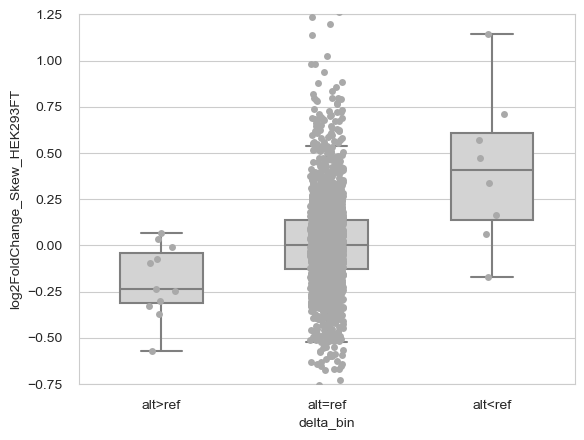

In [71]:
toplot = merged[merged['tamvar']=='tamvar']

f, ax = plt.subplots()

sns.boxplot(
    data = toplot, 
    x = 'delta_bin', 
    y = 'log2FoldChange_Skew_HEK293FT', 
    order = ['alt>ref', 'alt=ref', 'alt<ref'],
    color = 'lightgrey',
    width = 0.50,
    fliersize = 0, 
    ax = ax)

sns.stripplot(
    data = toplot, 
    x = 'delta_bin', 
    y = 'log2FoldChange_Skew_HEK293FT', 
    order = ['alt>ref', 'alt=ref', 'alt<ref'],
    color = 'darkgrey',
    ax = ax)

ax.set_ylim(-0.75, 1.25)

equal_group = toplot[toplot['delta_bin']=='alt=ref']['log2FoldChange_Skew_HEK293FT'].to_list()
# mann-whitney U test between "alt>ref" and "alt=ref" group
alt_group = toplot[toplot['delta_bin']=='alt>ref']['log2FoldChange_Skew_HEK293FT'].to_list()

t, p = scipy.stats.mannwhitneyu(alt_group, equal_group)
print(f'"alt>ref" and "alt=ref" groups p-value = {p}')

# mann-whitney U test between "alt<ref" and "alt=ref" group
ref_group = toplot[toplot['delta_bin']=='alt<ref']['log2FoldChange_Skew_HEK293FT'].to_list()

t, p = scipy.stats.mannwhitneyu(ref_group, equal_group)
print(f'"alt<ref" and "alt=ref" groups p-value = {p}')

f.savefig('PLOTS/Fig_5G.pdf', transparent = True)

## Figure S6B: spliceAI performance evaluation

In [72]:
# see "get_splice_site_rank.py" on how to generate this data
splice_site_rank = pd.read_csv('data/ptreseq_ranking_splice_site.csv', sep = '\t')

# if a reporter is 20% spliced or more
# check if spliceAI assign the observed donor and acceptor with the highest probability or not
# if yes -> correct prediction
# if no -> incorrect prediction

def evaluate_prediction(S_fraction, donor_rank, acceptor_rank):
    if S_fraction >= 0.20:
        if donor_rank <= 1:
            donor_acc = 'donor_rank_1_2'
        else:
            donor_acc = 'donor_rank_3+'
            
        if acceptor_rank <= 1:
            acceptor_acc = 'acceptor_rank_1_2'
        else:
            acceptor_acc = 'acceptor_rank_3+'
    else:
        donor_acc = 'not_spliced'
        acceptor_acc = 'not_spliced'
        
    return donor_acc, acceptor_acc

splice_site_rank['donor_acc'], splice_site_rank['acceptor_acc'] = zip(*splice_site_rank.apply(
                                                    lambda g: evaluate_prediction(
                                                        g['splicing_efficiency'], 
                                                        g['donor_rank'], 
                                                        g['acceptor_rank']), 
                                                    axis = 1
                                                        )
                                                         )

       site  correct  incorrect  correct_per  incorrect_per
0  acceptor     1088        102    91.428571       8.571429
1     donor     1131         59    95.042017       4.957983


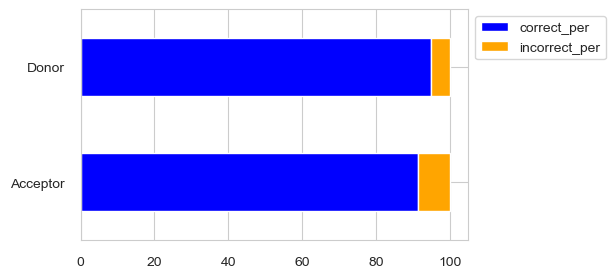

In [73]:
donor_correct_pred = len(splice_site_rank[splice_site_rank['donor_acc']=='donor_rank_1_2'])
donor_incorrect_pred = len(splice_site_rank[splice_site_rank['donor_acc']=='donor_rank_3+'])
acc_correct_pred = len(splice_site_rank[splice_site_rank['acceptor_acc']=='acceptor_rank_1_2'])
acc_incorrect_pred = len(splice_site_rank[splice_site_rank['acceptor_acc']=='acceptor_rank_3+'])

data = [
    ['acceptor', acc_correct_pred, acc_incorrect_pred],
    ['donor', donor_correct_pred, donor_incorrect_pred]
]

evaluation = pd.DataFrame(
    data, 
    columns = ['site', 'correct', 'incorrect']
)

evaluation['correct_per'] = evaluation['correct']*100/(evaluation['correct'] + evaluation['incorrect'])
evaluation['incorrect_per'] = evaluation['incorrect']*100/(evaluation['correct'] + evaluation['incorrect'])

print(evaluation)

sns.set_style("whitegrid")

f, ax = plt.subplots(figsize = (5, 3))

evaluation[['correct_per', 'incorrect_per']].plot.barh(
    stacked = True, 
    color = ['blue', 'orange'],
    ax = ax
)

ax.set_yticks([0, 1])
ax.set_yticklabels(['Acceptor', 'Donor'])

ax.legend(bbox_to_anchor = (1, 1))

f.savefig('PLOTS/Fig_S7B.pdf', transparent = True)

## Figure S6C: predicted location of donors and acceptors prediction

In [74]:
toplot1 = griesemer[griesemer['probability']>=0.30].reset_index(drop = True)
toplot1['start_norm'] = toplot1['best_donor'] - 720
toplot1['end_norm'] = toplot1['best_acceptor'] - 720
toplot1['mpra'] = 'griesemer'

toplot2 = siegel[siegel['probability']>=0.30].reset_index(drop = True)
toplot2['start_norm'] = toplot2['best_donor'] - 720
toplot2['end_norm'] = toplot2['best_acceptor'] - 720
toplot2['mpra'] = 'siegal'

toplot3 = zhao[zhao['probability']>=0.30].reset_index(drop = True)
toplot3['start_norm'] = toplot3['best_donor'] - 720
toplot3['end_norm'] = toplot3['best_acceptor'] - 720
toplot3['mpra'] = 'zhao'

toplot4 = fu[fu['probability']>=0.30].reset_index(drop = True)
toplot4['start_norm'] = toplot4['best_donor'] - 720
toplot4['end_norm'] = toplot4['best_acceptor'] - 720
toplot4['mpra'] = 'griesemer'

#toplot = toplot.astype({'start_norm': int})

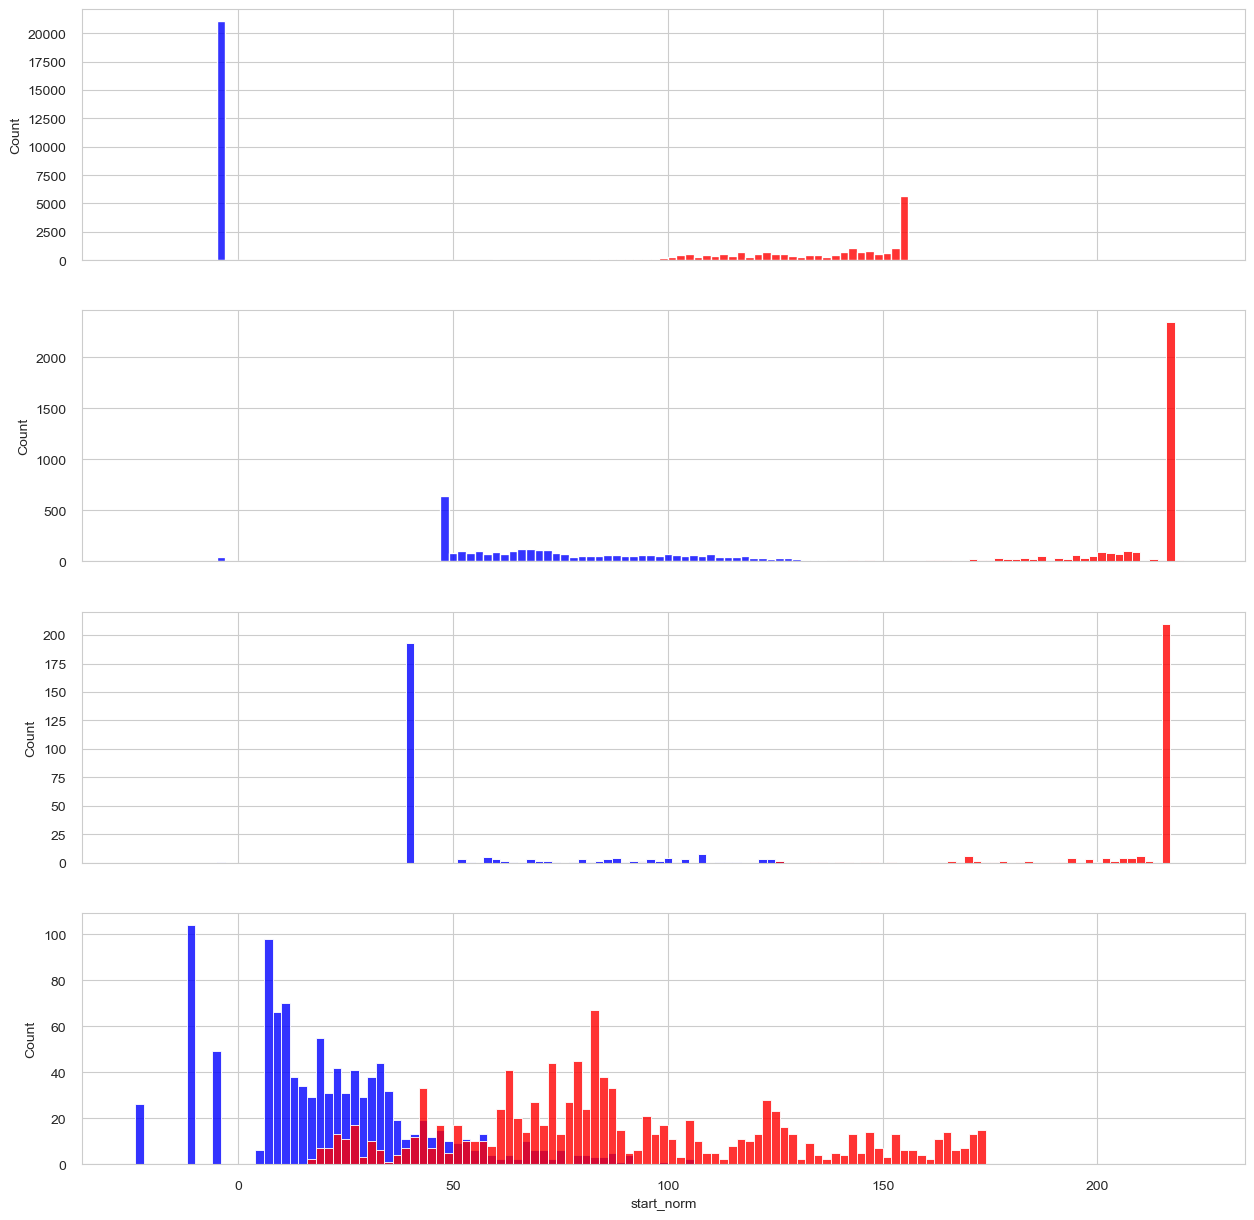

In [75]:
f, axs = plt.subplots(nrows = 4, figsize = (15, 15), sharex = True)

for ax, data in zip(axs, [toplot1, toplot2, toplot3, toplot4]):
    sns.histplot(
        data = data, 
        x = 'start_norm', 
        binwidth = 2,
        color = 'blue',
        label = 'donor',
        alpha = 0.8,
        ax = ax
    )

    sns.histplot(
        data = data, 
        x = 'end_norm', 
        binwidth = 2,
        label = 'acceptor',
        color = 'red',
        alpha = 0.8,
        ax = ax
    )

#ax1.set_xlim(-20, 220)
#ax2.set_xlim(-20, 220)

#ax1.set_ylim(19000, 20000)
#ax2.set_ylim(0, 6000)

f.savefig('PLOTS/Fig_S7C.pdf', transparent = True)

## Figure S6E: predicted probability of other reporter genes

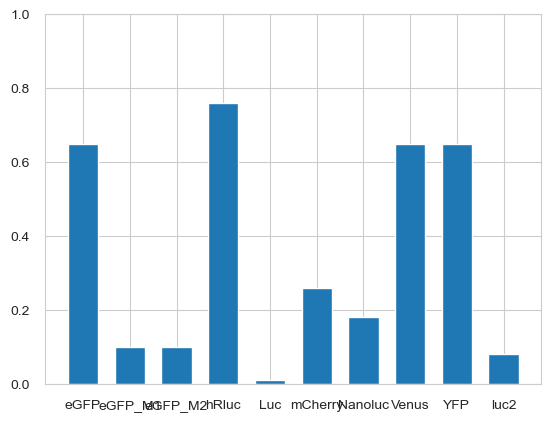

In [76]:
p = ['eGFP', 'eGFP_M1', 'eGFP_M2', 'hRluc', 'Luc', 'mCherry', 'Nanoluc', 'Venus', 'YFP', 'luc2']
probs = [0.65, 0.1, 0.1, 0.76, 0.01, 0.26, 0.18, 0.65, 0.65, 0.08] # spliceAI probability

f, ax = plt.subplots()

ax.bar(p, probs, width = 0.65)

ax.set_ylim(0, 1.0)

f.savefig('PLOTS/Fig_S7E.pdf', transparent = True)

## Figure S7: Plot expression of validated variants

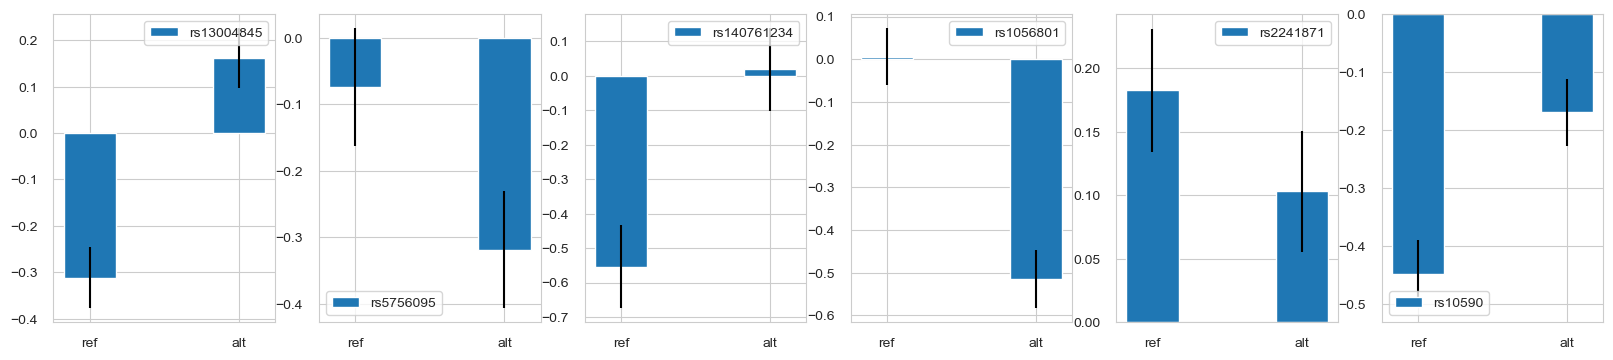

In [77]:
vars_to_plot = ['rs13004845', 'rs5756095', 'rs140761234', 'rs1056801', 'rs2241871', 'rs10590']

f, axs = plt.subplots(ncols = 6, figsize = (20, 4))

for var, ax in zip(vars_to_plot, axs):
    toplot = griesemer_result[griesemer_result['mpra_variant_id'].str.contains(var)]
    data = [toplot['log2FoldChange_Ref_HEK293FT'].values[0], toplot['log2FoldChange_Alt_HEK293FT'].values[0]]
    SE = [toplot['lfcSE_Ref_HEK293FT'].values[0], toplot['lfcSE_Alt_HEK293FT'].values[0]]
    
    ax.bar(['ref', 'alt'], data, width = 0.35, yerr = SE, label = var)
    ax.legend()

f.savefig('PLOTS/Fig_5I_S8.pdf', transparent = True)